### 使い方
```
1．Google Driveにhandsignというディレクトリを作成
2. handsignに添付のmoviesの中身をすべて入れる
3. 以降のセルを実行
4. 学習後に得られたモデルファイル(vgg16.hdf5)と(vgg16.json)を(realtime_handsign.ipynb)で読み込む。
```

### Google Driveと連携

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls  /content/drive/MyDrive/handsign

hebi  hituji  inoshishi  inu  nezumi  saru  tatu  tora	tori  uma  usagi  ushi


In [3]:
# 分類するクラス
classes = ['nezumi', 'ushi', 'tora', 'usagi', 'tatu', 'hebi', 'uma', 'hituji', 'saru', 'tori', 'inu', 'inoshishi'] 

### train, val, testディレクトリを作成

In [4]:
import os
for dir in ['train', 'val', 'test']:
    for c in classes:
        os.makedirs(f'{dir}/{c}', exist_ok=True)

### Drive中のmp4ファイルを使ってjpgファイルを作成＆振り分け

In [6]:
import shutil
MOVIE_DIR = '/content/drive/MyDrive/handsign'
for c in classes:
    files = os.listdir(f'{MOVIE_DIR}/{c}') # handsing/class_name/以下のファイルを取得
    for f in files:
        if f.split('.')[-1] == 'mp4': # failがmp4ならjpg化
            if 'test' in f: # mp4のファイル名に"test"が含まれていればtest用ファイルにする
                cmd = f'ffmpeg -i {MOVIE_DIR}/{c}/{f} -loglevel error -vcodec mjpeg /content/test/{c}/{c}_%04d.jpg'
                !{cmd}
            else: # それ以外はtrainディレクトリ
                name = f.split('.')[0]
                cmd = f'ffmpeg -i {MOVIE_DIR}/{c}/{f} -loglevel error -vcodec mjpeg /content/train/{c}/{name}_%04d.jpg'
                !{cmd}
        elif f.split('.')[-1] == 'jpg': # その他jpgファイルもtrainディレクトリに格納
            shutil.move(f'{SAVE_DIR}/{c}/{f}', f'./train/{c}/')

In [7]:
# 実行環境
%cd /content/
!ls

/content
drive  sample_data  test  train  val


### 検証データ分割関数

In [8]:
import os
from random import sample
import shutil
# 指定したtrainディレクトリ中のファイルをrateで指定した分valディレクトリに移動させる
def random_move(dir, rate=0.3):
    train_list = os.listdir(f'./train/{dir}')
    n = int(len(train_list) * rate)
    val_list = sample(train_list, n)
    for f in val_list:
        shutil.move(f'./train/{dir}/{f}', f'./val/{dir}/')

### 学習データと検証用データ(7:3)に分割

In [9]:
for c in classes:
    random_move(c)

### ディレクトリごとファイル数確認

In [10]:
!ls

drive  sample_data  test  train  val


In [11]:
import os
from glob import glob
print('train')
print(len(glob('./train/*/*.jpg')))
for c in classes:
    print(c,': ',len(glob(f'./train/{c}/*.jpg')))

print('val')
print(len(glob('./val/*/*.jpg')))
for c in classes:
    print(c,': ',len(glob(f'./val/{c}/*.jpg')))

print('test')
print(len(glob('./test/*/*.jpg')))
for c in classes:
    print(c,': ',len(glob(f'./test/{c}/*.jpg')))

train
72859
nezumi :  6604
ushi :  6121
tora :  5929
usagi :  5900
tatu :  5820
hebi :  6394
uma :  6107
hituji :  6046
saru :  5859
tori :  6305
inu :  5881
inoshishi :  5893
val
31219
nezumi :  2830
ushi :  2623
tora :  2541
usagi :  2528
tatu :  2493
hebi :  2739
uma :  2617
hituji :  2591
saru :  2510
tori :  2702
inu :  2520
inoshishi :  2525
test
7244
nezumi :  614
ushi :  624
tora :  608
usagi :  604
tatu :  525
hebi :  677
uma :  580
hituji :  564
saru :  505
tori :  555
inu :  555
inoshishi :  833


## VGG16

In [18]:
import os
import random
import glob
import matplotlib.pyplot as plt 
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping


classes = ['nezumi', 'ushi', 'tora', 'usagi', 'tatu', 'hebi', 'uma', 'hituji', 'saru', 'tori', 'inu', 'inoshishi'] 
nb_classes = len(classes)

#train val dir
train_dir = './train'
val_dir = './val'
test_dir = './test'
model_dir = './model'
train_batch_size = 1024
val_batch_size = 1024

#num samples
train_samples = glob.glob(train_dir + '/*/*.jpg')
val_samples = glob.glob(val_dir + '/*/*.jpg')
train_samples = len(train_samples)
val_samples = len(val_samples)
print(train_samples)
print(val_samples)

#img size
img_w, img_h = 90, 45

#keras image data generator
train_datagen = ImageDataGenerator(rescale = 1.0/255, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_w,img_h),
    color_mode = 'rgb',
    classes = classes,
    class_mode = 'categorical',
    batch_size = train_batch_size
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_w,img_h),
    color_mode = 'rgb',
    classes = classes,
    class_mode = 'categorical',
    batch_size = val_batch_size
)

#TO save model
checkpoint = ModelCheckpoint(
    filepath = os.path.join(
        model_dir,
        'vgg16_{epoch:02d}.hdf5'
    ),
    save_best_only=True
)

#TO early stopping
early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='auto')

### model ###
#VGG16
input_tensor = Input(shape=(img_w,img_h,3))
# include_top=False: 全結合層を除外
vgg16_model  = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(nb_classes, activation='softmax'))
vgg16 = Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))

# 図3における14層目までのモデル重みを固定（VGG16のモデル重みを用いる）
for layer in vgg16.layers[:15]:
    layer.trainable = False

#hyper param
vgg16.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.99),
              metrics=['accuracy'])

#train 
epoch = 10
vgg16_history = vgg16.fit(
    train_generator,
    steps_per_epoch=(train_samples//train_batch_size),
    epochs=epoch,
    validation_data=val_generator,
    callbacks=[checkpoint,early_stopping]
)
print(vgg16_history.history)

72859
31219
Found 72859 images belonging to 12 classes.
Found 31219 images belonging to 12 classes.
Epoch 1/10
71/71 [==============================] - 160s 2s/step - loss: 2.3780 - accuracy: 0.2042 - val_loss: 2.0579 - val_accuracy: 0.3581
Epoch 2/10
71/71 [==============================] - 158s 2s/step - loss: 1.6479 - accuracy: 0.5012 - val_loss: 1.0823 - val_accuracy: 0.6740
Epoch 3/10
71/71 [==============================] - 158s 2s/step - loss: 0.8453 - accuracy: 0.7267 - val_loss: 0.5232 - val_accuracy: 0.8347
Epoch 4/10
71/71 [==============================] - 158s 2s/step - loss: 0.4755 - accuracy: 0.8457 - val_loss: 0.3020 - val_accuracy: 0.9008
Epoch 5/10
71/71 [==============================] - 158s 2s/step - loss: 0.3081 - accuracy: 0.9005 - val_loss: 0.1843 - val_accuracy: 0.9454
Epoch 6/10
71/71 [==============================] - 158s 2s/step - loss: 0.2143 - accuracy: 0.9320 - val_loss: 0.1395 - val_accuracy: 0.9569
Epoch 7/10
71/71 [==============================] - 15

### テスト

In [19]:
test_dir = './test'
test_samples = glob.glob(test_dir + '/*/*.jpg')
test_samples = len(test_samples)
print(test_samples)
test_batch_size = 16
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_w,img_h),
    color_mode = 'rgb',
    classes = classes,
    class_mode = 'categorical',
    batch_size = test_batch_size,
    shuffle=False
)
step_size = test_samples // test_batch_size
vgg16.evaluate(test_generator, steps=step_size)

7244
Found 7244 images belonging to 12 classes.
452/452 [==============================] - 9s 19ms/step - loss: 0.2999 - accuracy: 0.8962


[0.2998763620853424, 0.8961559534072876]

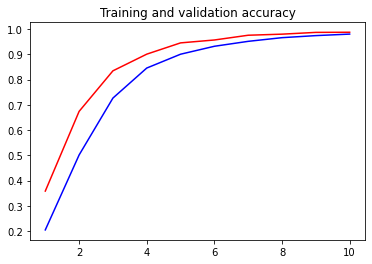

In [20]:
#plot 
acc = vgg16_history.history['accuracy']
val_acc = vgg16_history.history['val_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

epochs = epoch

plt.figure()
plt.plot(range(1,epochs+1),acc,'b',label = 'traning accracy')
plt.plot(range(1,epochs+1),val_acc,'r',label='validation accracy')
plt.title('Training and validation accuracy')
plt.show()

### モデル構造＆重みの保存

In [22]:
# モデル構造の保存
open("./vgg16.json","w").write(vgg16.to_json())

# 学習済みの重みを保存
vgg16.save_weights("./vgg16.hdf5")

In [21]:
val_generator.class_indices

{'hebi': 5,
 'hituji': 7,
 'inoshishi': 11,
 'inu': 10,
 'nezumi': 0,
 'saru': 8,
 'tatu': 4,
 'tora': 2,
 'tori': 9,
 'uma': 6,
 'usagi': 3,
 'ushi': 1}